In [82]:
# objective : detecting suspicious communication specificly (cyber bulling, threatning, terirosim ) from any type of txt data

In [83]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import pandas as pd 
import nltk
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

import re, os
for dirname, _, filenames in os.walk('data/dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/dataset/nytimes.csv
data/dataset/suspicious-tweets.csv
data/dataset/result.csv
data/dataset/guardian.csv


In [84]:
df = pd.read_csv('data/dataset/suspicious-tweets.csv')

df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
0        6145   6133  went to the mall and had dinner out yay  tori-...    2
1       53855  53574                             @tweetchild  Clean Me!    7

In [85]:
# Count the number of characters in each message
df['length'] = df['message'].apply(len)
df.head()

,message,label,length
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",1,115
1,is upset that he can't update his Facebook by ...,1,111
2,@Kenichan I dived many times for the ball. Man...,1,89
3,my whole body feels itchy and like its on fire,0,47
4,"@nationwideclass no, it's not behaving at all....",1,111


In [86]:
# Use for pre-test only 11 number of elements!
df_labels = df['label']
df_labels.head(11)

0     1
1     1
2     1
3     0
4     1
5     1
6     1
7     1
8     1
9     1
10    1
Name: label, dtype: int64

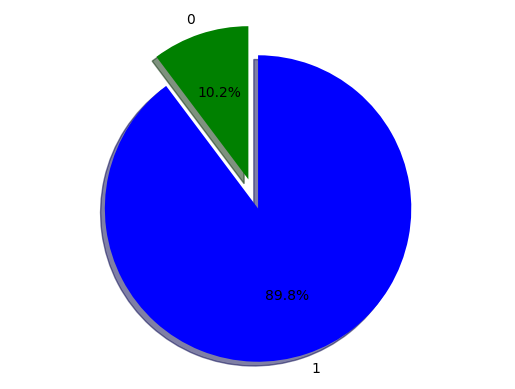

In [87]:
# Only for hinstogram
count_Class = pd.value_counts(df.label, sort = True)

# Data
labels = '0', '1'
sizes = [count_Class[0], count_Class[1]]
colors = ['green', 'blue']
explode = (0.1, 0.1)


plt.pie(sizes, explode = explode, labels = labels, colors = colors,
        autopct = '%1.1f%%', shadow = True, startangle = 90)
plt.axis('equal')
plt.show()

In [88]:
# Preprocess text and clean string
def preprocess_text(sen):
    sentence = re.sub('(https?:\/\/)?([\da-z\.-]+)\.([a-z\.]{2,6})([\/\w \.-]*)',' ',sen) # Removing html tags
    sentence = re.sub('[^a-zA-Z]', ' ', sentence) # Remove punctuations and numbers
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence) # Single character removal
    sentence = re.sub(r'\s+', ' ', sentence) # Removing multiple spaces
    sentence = sentence.replace("ain't", "am not").replace("aren't", "are not")
    sentence = ' '.join(text.lower() for text in sentence.split(' ')) # Lowering cases
    sw = stopwords.words('english')
    sentence = ' '.join(text for text in sentence.split() if text not in sw) #removing stopwords
    #sentence = ' '.join(text.lemmatize() for text in sentence.split()) #lemmatization
    return sentence

In [89]:
# Save in message, clean text
df['message'] = df.message.apply(preprocess_text)
# Tokenization each text
df['message'] = df['message'].apply(nltk.word_tokenize)

# The Porter stemming algorithm (or 'Porter stemmer') is a process for removing the commoner morphological 
# and inflexional endings from words in English. Its main use is as part of a term normalisation process that 
# is usually done when setting up Information Retrieval systems.
stemmer = PorterStemmer()
df['message'] = df['message'].apply(lambda x: [stemmer.stem(y) for y in x])

In [90]:
# is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
# -> ['upset', 'updat', 'facebook', 'text', 'might', 'cri', 'result', 'school', 'today', 'blah']
show = df['message']
show.head()

0    [switchfoot, bummer, shoulda, got, david, carr...
1                       [upset, updat, facebook, text]
2    [kenichan, dive, mani, time, ball, manag, save...
3               [whole, bodi, feel, itchi, like, fire]
4                   [nationwideclass, behav, mad, see]
Name: message, dtype: object

In [91]:
df['message'] = df['message'].apply(lambda x: ' '.join(x))

# Convert a collection of text documents to a matrix of token counts.
count_vect = CountVectorizer()
counts = count_vect.fit_transform(df['message']);

In [27]:
transformer = TfidfTransformer().fit(counts)
counts = transformer.fit_transform(counts)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(counts, df['label'], test_size=0.3, random_state=69)

In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [30]:
# implementing naive bayes
NB = MultinomialNB().fit(X_train, y_train)

predicted = NB.predict(X_test)
print(np.mean(predicted == y_test))

0.9002222222222223


In [31]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       1.00      0.04      0.08      1869
           1       0.90      1.00      0.95     16131

    accuracy                           0.90     18000
   macro avg       0.95      0.52      0.51     18000
weighted avg       0.91      0.90      0.86     18000



In [16]:
print(confusion_matrix(y_test, predicted))

[[   73  1796]
 [    0 16131]]


In [32]:
# implementing SVM
sv = SVC().fit(X_train, y_train)

predicted = sv.predict(X_test)
print(np.mean(predicted == y_test))

0.9588888888888889


In [33]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.97      0.62      0.76      1869
           1       0.96      1.00      0.98     16131

    accuracy                           0.96     18000
   macro avg       0.96      0.81      0.87     18000
weighted avg       0.96      0.96      0.95     18000



In [34]:
print(confusion_matrix(y_test, predicted))

[[ 1164   705]
 [   35 16096]]


In [35]:
# implementing disession tree

dt = DecisionTreeClassifier().fit(X_train, y_train)

predicted = dt.predict(X_test)
print(np.mean(predicted == y_test))

0.9716111111111111


In [36]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1869
           1       0.98      0.99      0.98     16131

    accuracy                           0.97     18000
   macro avg       0.93      0.91      0.92     18000
weighted avg       0.97      0.97      0.97     18000



In [37]:
print(confusion_matrix(y_test, predicted))

[[ 1562   307]
 [  204 15927]]


In [38]:
# implementing adabost 
ab = AdaBoostClassifier().fit(X_train, y_train)

In [39]:
predicted = ab.predict(X_test)

print(np.mean(predicted == y_test))

0.9655555555555555


In [40]:
print(classification_report(y_test,predicted))

              precision    recall  f1-score   support

           0       0.95      0.70      0.81      1869
           1       0.97      1.00      0.98     16131

    accuracy                           0.97     18000
   macro avg       0.96      0.85      0.90     18000
weighted avg       0.97      0.97      0.96     18000



In [41]:
print(confusion_matrix(y_test, predicted))

[[ 1314   555]
 [   65 16066]]


In [42]:
# converting content to lower case
pred = (df['message'].str.lower())
# printing predictions made by model
print("prediction: {}". format(dt.predict(count_vect.transform(pred.values.astype('U')))))
# saving predictions in a variable
my_pred = dt.predict(count_vect.transform(pred.values.astype('U')))

# saving predicted labels in .csv file
df['autotag'] = my_pred
df.to_csv('data/dataset/result.csv',index = False)

prediction: [1 1 1 ... 1 1 1]


In [43]:
# getting the number of -ve , +ve  predictions 
positive = 0
negative = 0

for v in my_pred:
 if (v == 1):
  positive += 1
 elif (v == 0):
  negative += 1

In [44]:
# function for quality measurement (can be set to required parameters)
def quality(pos,total):
    if((pos*100)/total >= 0 and (pos*100)/total <=24 ):
        print('Quality: Very Negative')
    elif((pos*100)/total >= 25 and (pos*100)/total <=49 ):
        print('Quality: Negative')
    elif((pos*100)/total >= 50 and (pos*100)/total <=74 ):
        print('Quality: Positive')
    elif((pos*100)/total >= 75 and (pos*100)/total <=100 ):
        print('Quality: Very Positive')

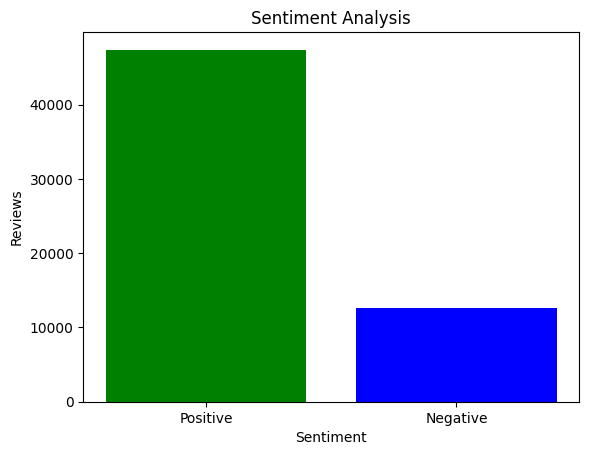

Sentiment Analysis - Positive: 47394, Negative: 12606
Quality: Very Positive


In [45]:
# importing library to plot charts
import matplotlib.pyplot as plt 
  
# x-coordinates of left sides of bars  
left = [100, 200 ] 
  
# heights of bars 
height = [positive,negative] 
  
# labels for bars 
tick_label = ['Positive', 'Negative'] 
  
# plotting a bar chart 
plt.bar(left, height, tick_label = tick_label, width = 80, color = ['green','blue']) 
  
# naming the x-axis 
plt.xlabel('Sentiment') 
# naming the y-axis 
plt.ylabel('Reviews') 
# plot title 
plt.title('Sentiment Analysis') 
  
# function to show the plot 
plt.show() 
print ("Sentiment Analysis - Positive: "+str(positive)+", Negative: "+str(negative))
quality(positive,(positive+negative))

In [46]:
# getting negativity 
negativeity = (negative*100)/(positive+negative)
positivity = (positive*100)/(positive+negative)